# Imputation and Integration for Mouse Embryo data

## loading package

In [ ]:
import scanpy as sc
import torch as th
import scanpy as sc
import pandas as pd
import torch.nn as nn
from SpaMIE.create_graph import Sagegraph
from SpaMIE.spamie_main import Sagewrapper
device = th.device('cuda:0' if th.cuda.is_available() else 'cpu')

from matplotlib import rcParams

config = {
    "font.family":'Times New Roman',  
    "font.size":12,
    "axes.unicode_minus": False 
}
rcParams.update(config)

## Imputation

###  ATAC imputation RNA

In [3]:

file_fold = '/data/xiangdw/data/data/MouseEmbryo/'
a = []
layers_nums = 3
for i in range(1):
    seeds = i+1
    adata_omics1 = sc.read_h5ad(file_fold + 'MouseEmbryo25um_ATAC.h5ad')
    adata_omics2 = sc.read_h5ad(file_fold + 'MouseEmbryo25um_RNA.h5ad')
    adata_omics1.obs['x_coord'] = adata_omics1.obs['row'].values 
    adata_omics1.obs['y_coord'] = adata_omics1.obs['col'].values 
    adata_omics1.obsm['spatial'] = adata_omics1.obs[['x_coord', 'y_coord']].values
    adata_omics2.obs['x_coord'] = adata_omics2.obs['row'].values 
    adata_omics2.obs['y_coord'] = adata_omics2.obs['col'].values 
    adata_omics2.obsm['spatial'] = adata_omics2.obs[['x_coord', 'y_coord']].values
    modalities = [adata_omics1, adata_omics2]
    g_spatial_omics1, g_feature_omics1, adata_omics1, adata_omics2 = Sagegraph(modalities, device, datatype='Spatial-epigenome-transcriptome-ATAC-RNA', batch=False)
    output_dir = '/data/xiangdw/data/pred result/'
    weight = [0,0,1]

    pred_name = 'mouseEmbryo_SpaMIE_RNA_'+str(layers_nums)+'_pred.csv'
    true_name = 'mouseEmbryo_SpaMIE_RNA_'+str(layers_nums)+'_truth.csv'

    in_feat = adata_omics1.obsm['feat'].shape[1]
    out_feat = adata_omics2.X.shape[1]

    model = Sagewrapper(seed=(int(seeds)), device=device, in_feat=in_feat, n_hidden=512, out_feat=out_feat, task='prediction', datatype='simu',
                        layers_nums=int(layers_nums), weight=weight, epoch=100, res_type='res_add', activation=nn.LeakyReLU
                        , sagetype='mean', lr=2e-3, lr2 = 0.001)

    adata_omics1_pred, adata_omics2_pred, test_idx, train_idx,wt,alph  = model.fit( adata_omics1, adata_omics2, g_spatial_omics1, g_feature_omics1,  
                                                                                    output_dir=output_dir, pred_name=pred_name, 
                                                                                    true_name=true_name, weight=True, save_csv=False)



/data/xiangdw/MODEL/SpaMIE/spamie_net.py:98: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  self.alpha = F.softmax(torch.squeeze(self.vu) + 1e-6)


### RNA Impute ATAC

In [4]:
file_fold = '/data/xiangdw/data/data/MouseEmbryo/'
a = []
layers_nums = 3
for i in range(1):
    seeds = i+1
    adata_omics1 = sc.read_h5ad(file_fold + 'MouseEmbryo25um_RNA.h5ad')
    adata_omics2 = sc.read_h5ad(file_fold + 'MouseEmbryo25um_ATAC.h5ad')

    adata_omics1.obs['x_coord'] = adata_omics1.obs['row'].values 
    adata_omics1.obs['y_coord'] = adata_omics1.obs['col'].values 
    adata_omics1.obsm['spatial'] = adata_omics1.obs[['x_coord', 'y_coord']].values
    adata_omics2.obs['x_coord'] = adata_omics2.obs['row'].values 
    adata_omics2.obs['y_coord'] = adata_omics2.obs['col'].values 
    adata_omics2.obsm['spatial'] = adata_omics2.obs[['x_coord', 'y_coord']].values

    modalities = [adata_omics1, adata_omics2]
    g_spatial_omics1, g_feature_omics1, adata_omics1, adata_omics2 = Sagegraph(modalities, device, datatype='Spatial-epigenome-transcriptome-RNA-ATAC', batch=False)
    output_dir = '/data/xiangdw/data/pred result/'
    weight = [0,0,0]

    pred_name = 'mouseEmbryo_SpaMIE_ATAC_'+str(layers_nums)+'_pred.csv'
    true_name = 'mouseEmbryo_SpaMIE_ATAC_'+str(layers_nums)+'_truth.csv'

    in_feat = adata_omics1.obsm['feat'].shape[1]
    out_feat = adata_omics2.X.shape[1]

    model = Sagewrapper(seed=(int(seeds)), device=device, in_feat=in_feat, n_hidden=512, out_feat=out_feat, task='prediction', datatype='simu',
                        layers_nums=int(layers_nums), weight=weight, epoch=300, res_type='res_add', activation=nn.LeakyReLU
                        , sagetype='gcn', lr=1e-4, lr2 = 0.001)

    adata_omics1_pred, adata_omics2_pred, test_idx, train_idx,wt,alph  = model.fit(adata_omics1, adata_omics2, g_spatial_omics1, g_feature_omics1,  
                                                                                    output_dir=output_dir, pred_name=pred_name, 
                                                                                    true_name=true_name, weight=True, save_csv=False)



/data/xiangdw/conda_env/GNNS/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:61: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/data/xiangdw/MODEL/SpaMIE/spamie_net.py:98: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  self.alpha = F.softmax(torch.squeeze(self.vu) + 1e-6)


## Integration

In [ ]:
import os
import dgl
import pandas as pd
import sys
import scanpy as sc
import importlib 
import torch as th
import torch.nn as nn
from model_integration import *

from matplotlib import rcParams

config = {
    "font.family":'Times New Roman', 
     "font.size":20, 
    "axes.unicode_minus": False 
}
rcParams.update(config)

/data/xiangdw/MODEL


In [ ]:
import torch.nn.functional as F
from SpaMIE.create_graph import Sagegraph
from SpaMIE.spamie_main import Sagewrapper
import numpy as np
from model_integration import set_seed
device = th.device('cuda:1' if th.cuda.is_available() else 'cpu')


for i in range(1): 
    seeds = str(i+1)
    path = '/data/xiangdw/data/data/MouseEmbryo/'
    adata_omics1 = sc.read_h5ad(path + 'MouseEmbryo25um_ATAC.h5ad')
    adata_omics2 = sc.read_h5ad(path + 'MouseEmbryo25um_RNA.h5ad')

    adata_omics1.obs['x_coord'] = adata_omics1.obs['row'].values 
    adata_omics1.obs['y_coord'] = adata_omics1.obs['col'].values 
    adata_omics1.obsm['spatial'] = adata_omics1.obs[['x_coord', 'y_coord']].values
    adata_omics2.obs['x_coord'] = adata_omics2.obs['row'].values 
    adata_omics2.obs['y_coord'] = adata_omics2.obs['col'].values 
    adata_omics2.obsm['spatial'] = adata_omics2.obs[['x_coord', 'y_coord']].values

    set_seed(2024) 

    modalities = [adata_omics1, adata_omics2]
    g_spatial_omics1, g_feature_omics1, g_spatial_omics2, g_feature_omics2, adata_omics1, adata_omics2 = Sagegraph(modalities, device, task='Integration',
                                                                                                                   datatype="Spatial-epigenome-transcriptome-RNA-ATAC",batch=False)

    in_feat = adata_omics1.obsm['feat'].shape[1]
    out_feat = adata_omics2.X.shape[1]
    weight = [1,1,1]
    model = Sagewrapper(seed=(int(seeds)), device=device, in_feat=in_feat, n_hidden=256, out_feat=out_feat, task='integration', datatype='simu',
                        layers_nums=int(3), weight=weight, epoch=600, res_type='res_add', activation=nn.LeakyReLU
                        , sagetype='mean', lr=2e-4, lr2 = 0.002)

    output  = model.fit(adata_omics1, adata_omics2, g_spatial_omics1, g_feature_omics1,
                         g_spatial_omics2, g_feature_omics2,  weight_factors=[3,1,1,1])

    adata_omics2.obsm['SpaMIE'] = output[0].detach().cpu().numpy()
    

/data/xiangdw/conda_env/GNNS/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:61: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/data/xiangdw/MODEL/SpaMIE/spamie_net.py:98: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  self.alpha = F.softmax(torch.squeeze(self.vu) + 1e-6)
/data/xiangdw/MODEL/SpaMIE/spamie_net.py:66: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  self.alpha = F.softmax(torch.squeeze(self.vu) + 1e-6)


Searching resolution...
resolution=0.9510000000000001, cluster number=11
resolution=0.901, cluster number=9


/data/xiangdw/conda_env/GNNS/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'SpaMIE'}, xlabel='spatial1', ylabel='spatial2'>

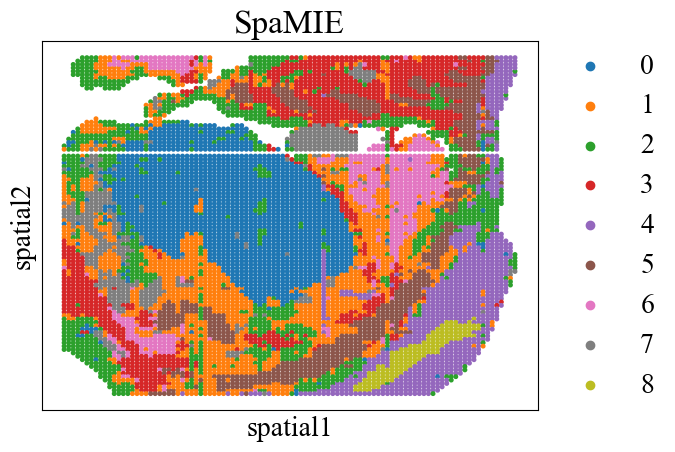

In [ ]:
from SpatialGlue.utils import clustering
tool = 'louvain'
clustering(adata_omics2, key='SpaMIE', add_key='SpaMIE',start=0.001, end=1.0, increment=0.05, n_clusters=9, method=tool, use_pca=False)
sc.pl.embedding(adata_omics2, basis='spatial', color=['SpaMIE'], title='SpaMIE', s=50, show=False)